In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/lfw.zip

Archive:  /content/drive/MyDrive/lfw.zip
replace __MACOSX/._lfw? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
path = '/content/lfw'

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Set the device to CUDA
    device = torch.device("cuda")
    print("CUDA device is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    # Fallback to CPU if CUDA is not available
    device = torch.device("cpu")
    print("CUDA device not found. Using CPU.")


CUDA device is available. Using GPU: Tesla T4


In [ ]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

torch.Size([250, 250, 3])


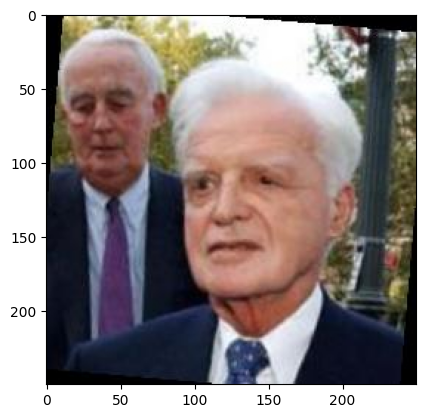

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

Autoencoders (AEs) and Variational Autoencoders (VAEs) are both types of neural network architectures used in unsupervised machine learning for various applications, but they differ in terms of their architecture and loss functions, leading to different capabilities and use cases. Here's a breakdown of the key differences between Autoencoders and VAEs in terms of applications, architecture, and loss functions:

**Applications:**

**Autoencoders (AEs):**

AEs are primarily used for dimensionality reduction, feature learning, and data denoising.
They can be applied in tasks such as image compression, anomaly detection, and image generation (though less effectively compared to VAEs).
AEs are deterministic and do not inherently model probabilistic distributions.

**Variational Autoencoders (VAEs):**

VAEs are designed for generative modeling and probabilistic representation learning.
They are particularly well-suited for tasks like image generation, style transfer, and semi-supervised learning.
VAEs explicitly model the probability distribution of the latent space, enabling better control over data generation.

**Architecture:**

**Autoencoders (AEs):**

AEs consist of an encoder network and a decoder network.
The encoder compresses the input data into a fixed-size latent representation (encoding).
The decoder then reconstructs the input data from this encoding.
The architecture is deterministic and doesn't involve stochastic sampling.

**Variational Autoencoders (VAEs):**

VAEs also consist of an encoder and a decoder.
However, VAEs introduce a probabilistic element by modeling the latent space as a probability distribution (usually Gaussian).
Instead of a fixed encoding, VAEs output the parameters (mean and variance) of the latent distribution.
Sampling from this distribution during training introduces randomness, making VAEs generative models.

**Loss Function:**

**Autoencoders (AEs):**

AEs typically use a mean squared error (MSE) or binary cross-entropy loss function.
The loss measures the difference between the input and the reconstructed output.

**Variational Autoencoders (VAEs):**

VAEs use a combination of two loss components: a reconstruction loss and a regularization loss (Kullback-Leibler divergence).
The reconstruction loss encourages the model to generate data that closely resembles the input.
The regularization loss encourages the latent distribution to be close to a standard Gaussian distribution, promoting disentangled and continuous representations.


In summary, Autoencoders are simpler, deterministic models primarily used for dimensionality reduction and data reconstruction tasks. Variational Autoencoders, on the other hand, are probabilistic generative models capable of modeling complex data distributions, making them suitable for various generative tasks and representation learning with more structured latent spaces. The inclusion of probabilistic modeling and the specific loss functions used in VAEs differentiate them from traditional Autoencoders.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        # Latent space
        self.fc_mu = nn.Linear(128 * 32 * 32, 20)
        self.fc_log_var = nn.Linear(128 * 32 * 32, 20)

        # Decoder layers
        self.decoder_fc = nn.Linear(20, 128 * 32 * 32)
        self.decoder_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.decoder_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def encoder(self, x):
        x = F.leaky_relu(self.encoder_conv1(x))
        x = F.leaky_relu(self.encoder_conv2(x))
        x = F.leaky_relu(self.encoder_conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

    def decoder(self, z):
        z = self.decoder_fc(z)
        z = z.view(-1, 128, 32, 32)
        x = F.relu(self.decoder_conv1(z))
        x = F.relu(self.decoder_conv2(x))
        x = torch.sigmoid(self.decoder_conv3(x))
        return F.interpolate(x, size=(250, 250), mode='bilinear', align_corners=False)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [ ]:

vae_model = VAE()

# Fetch a batch of images from the dataloader
next_batch = next(iter(dataloader))
batch_images, _ = next_batch

# Process a single image through the VAE
single_image = batch_images[0].unsqueeze(0)
with torch.no_grad():
    vae_model.eval()
    encoded_mu, encoded_logvar = vae_model.encoder(single_image)
    print(f"Encoder Output (mu) Shape: {encoded_mu.shape}")
    print(f"Encoder Output (logvar) Shape: {encoded_logvar.shape}")

    # Reparameterize and decode
    latent_space_samples = vae_model.reparameterize(encoded_mu, encoded_logvar)
    print(f"Latent Space Samples Shape: {latent_space_samples.shape}")
    output_images = vae_model.decoder(latent_space_samples)
    print(f"Decoder Output Shape: {output_images.shape}")


Encoder Output (mu) Shape: torch.Size([1, 20])
Encoder Output (logvar) Shape: torch.Size([1, 20])
Latent Space Samples Shape: torch.Size([1, 20])
Decoder Output Shape: torch.Size([1, 3, 250, 250])


To generate new samples in the latent space of a Variational Autoencoder (VAE), we need to follow these steps:

**Encoding the Input Data:**

We start by encoding an input data point (e.g., an image) using the VAE's encoder network. This step involves two outputs: encoded_mu (the mean of the latent space distribution) and encoded_logvar (the logarithm of the variance of the latent space distribution). These are typically produced by feedforward layers in the encoder.

**Reparameterization :**

To generate new samples, we employ the reparameterization trick. This involves introducing randomness into the latent space while ensuring that the gradients can still be backpropagated through the network. Here's how it works:
Sample a vector of random values epsilon from a standard normal distribution (mean 0, standard deviation 1). This vector has the same dimension as the latent space.

**Sampling from the Latent Space:**

Using the encoded_mu and encoded_logvar obtained from the encoder, we transform the epsilon vector into a sample in the latent space. This is done as follows:
Calculate a scaled vector by multiplying epsilon by the square root of exp(encoded_logvar / 2). This scaling ensures that the sample matches the distribution's variance as specified by encoded_logvar.
Add encoded_mu to this scaled vector. This step shifts the sample according to the distribution's mean, aligning it with the learned latent distribution.

**Decoding the Sample:**

Take the sampled point from the latent space and pass it through the VAE's decoder network. The decoder network maps the latent space sample back to the original data space.
Generated Sample

**Output:**

The output of the decoder represents a newly generated sample. In the case of image generation, it will be an image reconstructed from the sample in the latent space.
By following these steps, you generate new samples in the latent space of a VAE. The reparameterization trick allows for controlled and meaningful exploration of the latent space, producing diverse and coherent samples. This capability makes VAEs particularly useful for generative tasks like image generation, style transfer, and more.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [ ]:
total_params = sum(p.numel() for p in vae_model.parameters())
print("Total number of parameters in the model: ", total_params)

Total number of parameters in the model:  8254155


In [43]:
# Define the optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

def loss_function(predicted_img, original_img, mean, log_variance):
    """
    Compute the loss for VAE which is a sum of reconstruction loss and
    Kullback-Leibler divergence loss.

    :param predicted_img: The reconstructed image from the decoder.
    :param original_img: The original input image.
    :param mean: The mean from the VAE encoder's latent space.
    :param log_variance: The log variance from the VAE encoder's latent space.
    :return: Total VAE loss.
    """
    # Binary Cross-Entropy loss between the predicted and original images
    reconstruction_loss = F.binary_cross_entropy(predicted_img, original_img, reduction='sum')

    # Kullback-Leibler divergence loss computation
    KL_divergence_loss = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())

    # Total VAE loss is the sum of reconstruction and KL divergence losses
    total_vae_loss = reconstruction_loss + KL_divergence_loss

    return total_vae_loss



The loss function we've defined for our Variational Autoencoder (VAE) consists of two key terms: the Binary Cross-Entropy (BCE) loss and the Kullback-Leibler Divergence (KLD) loss. Let's delve into these terms and understand their roles:

**Binary Cross-Entropy (BCE) Loss:**

The BCE loss evaluates how well our VAE's reconstructed output (recon_x) aligns with the original input data (x).
It measures pixel-wise differences between the reconstructed image and the actual input image, penalizing any disparities.
Our aim with the BCE loss term is to encourage the VAE to generate reconstructions that closely match the original input data. In essence, it's responsible for ensuring accurate "reconstruction."

This is calculated using the F.binary_cross_entropy function, which computes the element-wise binary cross-entropy loss between the reconstructed output recon_x and the original input data x.

The reduction='sum' argument specifies that we want to sum up the losses for all elements in the tensors, effectively calculating the total loss across all data points.


**Kullback-Leibler Divergence (KLD) Loss:**

The KLD loss quantifies how closely the latent space distribution, which is learned and characterized by mu and logvar, matches a standard Gaussian distribution.
It quantifies the "distance" between the learned distribution and our desired Gaussian distribution.
Our goal with the KLD loss term is twofold:
First, it discourages the latent space from straying too far from a standard Gaussian distribution. This encourages a well-behaved and interpretable latent space.
Second, it helps in ensuring that our VAE learns disentangled and continuous representations in the latent space.

The KLD loss is calculated as follows:

1 + logvar - mu.pow(2) - logvar.exp()
logvar represents the logarithm of the variance of the learned latent space distribution.
mu represents the mean of the learned latent space distribution.
mu.pow(2) computes the element-wise square of the mean.
logvar.exp() calculates the element-wise exponentiation of the logarithm of the variance.
1 + logvar - mu.pow(2) - logvar.exp() computes the terms necessary for the KLD loss formula.
-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) computes the final KLD loss, where we sum all the elements and apply a scaling factor of -0.5.

Overall, the KLD loss controls the trade-off between data reconstruction (BCE loss) and the regularization of the latent space, which helps in preventing overfitting.

**Overall Loss Function:**

Our complete loss function is the sum of the BCE loss and the KLD loss.
This combination enables our VAE to find a balance between generating accurate reconstructions and maintaining a structured and regularized latent space.
By optimizing this combined loss, our VAE learns to generate meaningful and diverse samples in the latent space while ensuring that the latent space adheres to certain desirable properties.

In summary, the BCE loss term drives faithful reconstruction of input data, while the KLD loss term regularizes the latent space, making it well-behaved and interpretable. Striking a balance between these two components is essential for training an effective VAE capable of generating high-quality samples and meaningful representations in the latent space.







##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [44]:
import torch


# Instantiate the VAE model and move it to the device
vae_model = VAE().to(device)



num_epochs = 10  # Set the number of epochs

# Training loop
for epoch in range(num_epochs):
    vae_model.train()  # Set the model to training mode
    total_loss = 0

    for batch_idx, (data, _) in enumerate(dataloader):
        # Move the data to the device (GPU or CPU)
        data = data.to(device)

        optimizer.zero_grad()

        # Forward pass: Compute the reconstruction and the latent space variables
        reconstructed, mu, logvar = vae_model(data)

        # Compute the loss
        loss = loss_function(reconstructed, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Optionally print the training progress
        #if batch_idx % 10 == 0:
            #print(f"Epoch: {epoch + 1}/{num_epochs}, Batch: {batch_idx}/{len(dataloader)}, Loss: {loss.item() / len(data):.6f}")

    # Print the average loss for the epoch
    average_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Average loss: {average_loss:.4f}")




Epoch [1/10] Average loss: 102386.2978
Epoch [2/10] Average loss: 98265.9979
Epoch [3/10] Average loss: 97802.2873
Epoch [4/10] Average loss: 97488.9646
Epoch [5/10] Average loss: 97079.8756
Epoch [6/10] Average loss: 96776.6670
Epoch [7/10] Average loss: 96593.1949
Epoch [8/10] Average loss: 96438.0864
Epoch [9/10] Average loss: 96301.5454
Epoch [10/10] Average loss: 96179.5356


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

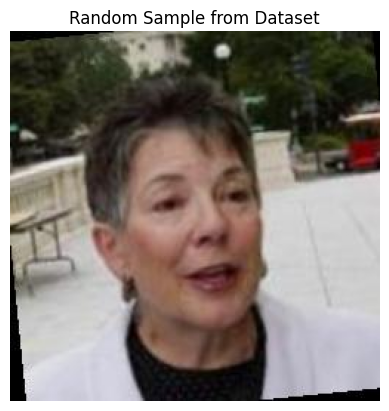

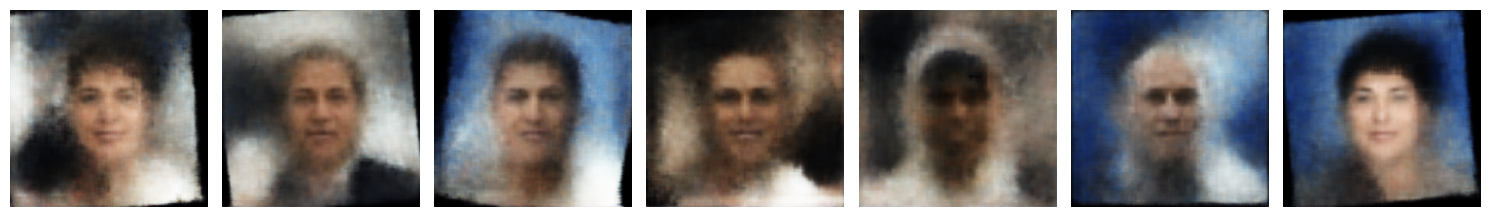

In [50]:
import matplotlib.pyplot as plt
import torch
import random

# Set the model to evaluation mode
vae_model.eval()

# Select a random image from the dataset
with torch.no_grad():
    # Choose a random index
    random_idx = random.randint(0, len(dataloader) - 1)
    for idx, (images, _) in enumerate(dataloader):
        if idx == random_idx:
            # Select the first image from the batch
            sample_image = images[0].to(device)
            # Prepare the image for display: transpose and move to CPU
            plt.imshow(sample_image.cpu().permute(1, 2, 0))
            plt.title("Random Sample from Dataset")
            plt.axis('off')  # Hide the axis
            plt.show()
            break  # Stop after finding the match

# Generate new images using the VAE model
with torch.no_grad():
    # Generate random latent variables
    random_latents = torch.randn(64, 20).to(device)
    # Use the model to create images from the latent variables
    new_images = vae_model.decoder(random_latents).cpu()

    # Display generated images
    fig, axarr = plt.subplots(1, 7, figsize=(15, 3))
    for ax, gen_img in zip(axarr, new_images[:7]):  # Display the first 7 generated images
        ax.imshow(gen_img.permute(1, 2, 0).clamp(0, 1))  # Ensure valid image display by clamping values
        ax.axis('off')
    plt.tight_layout()
    plt.show()
